In [122]:
import csv
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb

# Load pre-tokenized datasets

In [123]:
#load data
premise_train = []
hypothesis_train = []
targets_train = []
with open("hw2_data/snli_train.tsv") as tsvfile:
    fd = csv.reader(tsvfile, delimiter="\t")
    for row in fd:
        premise_train.append(row[0].lower().split())
        hypothesis_train.append(row[1].lower().split())
        if row[2] == 'contradiction':
            targets_train.append(0)
        elif row[2] == 'entailment':
            targets_train.append(1)
        elif row[2] == 'neutral':
            targets_train.append(2)
            
        
        
premise_val = []
hypothesis_val = []
targets_val = []
with open("hw2_data/snli_val.tsv") as tsvfile:
    fd = csv.reader(tsvfile, delimiter="\t")
    for row in fd:
        premise_val.append(row[0].lower().split())
        hypothesis_val.append(row[1].lower().split())
        if row[2] == 'contradiction':
            targets_val.append(0)
        elif row[2] == 'entailment':
            targets_val.append(1)
        elif row[2] == 'neutral':
            targets_val.append(2)

In [124]:
premise_train = premise_train[1:]
hypothesis_train = hypothesis_train[1:]
#targets_train = targets_train[1:]

premise_val = premise_val[1:]
hypothesis_val = hypothesis_val[1:]
#targets_val = targets_val[1:]

In [125]:
#check length of lists
print(len(premise_train))
print(len(hypothesis_train))
print(len(targets_train))

print(len(premise_val))
print(len(hypothesis_val))
print(len(targets_val))

100000
100000
100000
1000
1000
1000


In [126]:
MAX_SENTENCE_LENGTH_1 = len(max(premise_train, key = len))
MAX_SENTENCE_LENGTH_2 = len(max(hypothesis_train, key = len))

In [127]:
print(MAX_SENTENCE_LENGTH_1)
print(MAX_SENTENCE_LENGTH_2)

82
41


# Build vocab list and convert to indices

In [128]:
PAD_IDX = 0
UNK_IDX = 1
words_to_load = 50000

np.random.seed(0)
with open('wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    loaded_embeddings_ft[UNK_IDX] = np.random.rand(300)
    token2id = {'<pad>':PAD_IDX, '<unk>':UNK_IDX}
    id2token = {PAD_IDX:'<pad>', UNK_IDX:'<unk>'}
#     words_ft = {}
#     idx2words_ft = {}
#     ordered_words_ft = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
        token2id[s[0]] = i+2
        id2token[i+2] = s[0]
#         words_ft[s[0]] = i
#         idx2words_ft[i] = s[0]
#        ordered_words_ft.append(s[0])

In [129]:
# Lets check the dictionary by loading random token from it
import random
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))


Token id 8788 ; token tutorial
Token tutorial; token id 8788


In [130]:
#Convert tokens to indices
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

premise_train_indices = token2index_dataset(premise_train)
hypothesis_train_indices = token2index_dataset(hypothesis_train)

premise_val_indices = token2index_dataset(premise_val)
hypothesis_val_indices = token2index_dataset(hypothesis_val)

# Pytorch DataLoader

In [131]:
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_list_1, data_list_2, target_list):
        """
        @param data_list_1: list of tokens
        @param data_list_2: list of tokens
        @param target_list: list of targets

        """
        self.data_list_1 = data_list_1 
        self.data_list_2 = data_list_2
        self.target_list = target_list
        assert (len(self.data_list_1) == len(self.target_list))
        assert (len(self.data_list_2) == len(self.target_list))

    def __len__(self):
        return len(self.data_list_1)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx_1 = self.data_list_1[key][:MAX_SENTENCE_LENGTH_1]
        token_idx_2 = self.data_list_2[key][:MAX_SENTENCE_LENGTH_2]
        label = self.target_list[key]
        return [token_idx_1, len(token_idx_1), token_idx_2, len(token_idx_2), label]
    
def snli_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list_1 = []
    length_list_2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list_1.append(datum[1])
        length_list_2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec_1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH_1-datum[1])),
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec_1)
        
        padded_vec_2 = np.pad(np.array(datum[2]),
                                pad_width=((0, MAX_SENTENCE_LENGTH_2-datum[3])), 
                                mode="constant", constant_values=0)
        data_list_2.append(padded_vec_2)
    
    return [torch.from_numpy(np.array(data_list_1)), torch.LongTensor(length_list_1), 
            torch.from_numpy(np.array(data_list_2)), torch.LongTensor(length_list_2), 
            torch.LongTensor(label_list)]



In [411]:
# Build train and valid dataloaders
BATCH_SIZE = 32

train_dataset = SNLIDataset(premise_train_indices, hypothesis_train_indices, targets_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(premise_val_indices, hypothesis_val_indices, targets_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

for i, (data_1, data_2, lengths_1, lengths_2, labels) in enumerate(train_loader):
    print (data_1)
    print(data_2)
    print (labels)
    break

tensor([[  10,  348, 3303,  ...,    0,    0,    0],
        [ 108, 5558,  676,  ...,    0,    0,    0],
        [  10,  348,   20,  ...,    0,    0,    0],
        ...,
        [ 108,  356,   35,  ...,    0,    0,    0],
        [3892,  676,    9,  ...,    0,    0,    0],
        [  10,  818,    9,  ...,    0,    0,    0]])
tensor([ 7, 24, 11, 20, 13, 15, 20, 15, 13, 12, 18, 11, 18, 21, 20, 22, 33,  5,
        13,  8, 10, 10, 11, 16,  3, 12, 25, 12, 24, 15, 18,  6])
tensor([0, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 0])


# CNN based model

In [133]:
def emb_layer(weights_matrix, non_trainable = True):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.weight.data.copy_(torch.from_numpy(weights_matrix))
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer

In [404]:
class CNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, num_classes, kernel, pad, emb_size=300, dropout=0):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size, 
        self.embedding = emb_layer(weights_matrix, non_trainable=True)
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel, padding=pad)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel, padding=pad)
#         self.conv3 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel, padding=pad)
#         self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel, padding=pad)
        
        self.maxpool1 = nn.MaxPool1d(MAX_SENTENCE_LENGTH_1)
        self.maxpool2 = nn.MaxPool1d(MAX_SENTENCE_LENGTH_2)
        
        self.linear1 = nn.Linear(hidden_size*2, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x_1, lengths_1, x_2, lengths_2):
        batch_size_1, seq_len_1 = x_1.size()
        batch_size_2, seq_len_2 = x_2.size()

        embed1 = self.embedding(x_1)
        embed2 = self.embedding(x_2)
        
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size_1, seq_len_1, hidden1.size(-1))
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size_1, hidden1.size(-1), seq_len_1)
        hidden1 = self.maxpool1(hidden1)
        
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size_2, seq_len_2, hidden2.size(-1))
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size_2, hidden2.size(-1), seq_len_2)
        hidden2 = self.maxpool2(hidden2)
        
        concat = torch.cat([hidden1, hidden2], 1)
        concat = torch.sum(concat, dim=-1)
        logits = self.relu(self.linear1(concat))
        
        logits = self.dropout(logits)
        logits = self.linear2(logits)
        return logits

In [423]:
#Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    criterion = torch.nn.CrossEntropyLoss() 
    correct = 0
    total = 0
    loss = 0
    model.eval()
    for data_1, lengths_1, data_2, lengths_2, labels in loader:
        data_batch_1, length_batch_1, data_batch_2, length_batch_2,label_batch = data_1, lengths_1, data_2, lengths_2, labels
        outputs = F.softmax(model(data_batch_1, length_batch_1, data_batch_2, length_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss_i = criterion(outputs, labels)
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        loss += loss_i.item()
    return (100 * correct / total), loss/len(loader)


In [424]:
#Function for training the model
def train_model(model, learning_rate, num_epochs, weight_decay):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('The number of trained parameters: {}'.format(total_params))
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
    #scheduler.step()
        for i, (data_1, lengths_1, data_2, lengths_2, labels) in enumerate(train_loader):
            model.train()
            #data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_1, lengths_1, data_2, lengths_2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            # validate every 1000 iterations
            if i > 0 and i % 1000 == 0:
                # validate
                train_acc, train_loss = test_model(train_loader, model)
                val_acc, val_loss = test_model(val_loader, model)
            
                train_acc_list.append(train_acc)
                train_loss_list.append(train_loss)
                val_acc_list.append(val_acc)
                val_loss_list.append(val_loss)
                print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Train Acc: {}, Validation Loss: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), train_loss, train_acc, val_loss, val_acc))
    
    print ("After training for {} epochs".format(num_epochs))
    print ("Val Acc {}".format(val_acc_list[-1]))
    return train_acc_list, train_loss_list, val_acc_list, val_loss_list

In [425]:
model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=200, num_layers=2, num_classes=3, kernel=3, pad=1, emb_size=300, dropout=0)
train_acc_1, train_loss_1, val_acc_1, val_loss_1 = train_model(model, 3e-4, 5, 0)

The number of trained parameters: 381203
Epoch: [1/5], Step: [1001/3125], Train Loss: 1.0064571347618103, Train Acc: 56.202, Validation Loss: 1.010532658547163, Validation Acc: 55.2
Epoch: [1/5], Step: [2001/3125], Train Loss: 0.9674221991539002, Train Acc: 60.832, Validation Loss: 0.9737640470266342, Validation Acc: 58.3
Epoch: [1/5], Step: [3001/3125], Train Loss: 0.9533161267089844, Train Acc: 63.083, Validation Loss: 0.9577719699591398, Validation Acc: 60.7
Epoch: [2/5], Step: [1001/3125], Train Loss: 0.9433063172149658, Train Acc: 64.405, Validation Loss: 0.9560351055115461, Validation Acc: 61.1
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.9265738909339905, Train Acc: 64.897, Validation Loss: 0.9426767155528069, Validation Acc: 62.6
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9210552142524719, Train Acc: 66.481, Validation Loss: 0.9350864179432392, Validation Acc: 63.8
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.9123435682678223, Train Acc: 67.146, Validation Loss: 0.92805

In [405]:
model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=400,num_layers=2, num_classes=3, kernel=3, pad=1, emb_size=300, dropout=0)
train_acc_2, train_loss_2, val_acc_2, val_loss_2 = train_model(model, 3e-4, 5, 0)

The number of trained parameters: 1162403
Epoch: [1/5], Step: [1001/3125], Train Loss: 0.9897320270919799, Train Acc: 59.774, Validation Loss: 0.9967310670763254, Validation Acc: 58.8
Epoch: [1/5], Step: [2001/3125], Train Loss: 0.9665376406478882, Train Acc: 61.096, Validation Loss: 0.9756956081837416, Validation Acc: 60.4
Epoch: [1/5], Step: [3001/3125], Train Loss: 0.9394854960250855, Train Acc: 65.032, Validation Loss: 0.9488612003624439, Validation Acc: 62.8
Epoch: [2/5], Step: [1001/3125], Train Loss: 0.9222019939994812, Train Acc: 66.77, Validation Loss: 0.9367314875125885, Validation Acc: 63.5
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.9142345871925354, Train Acc: 66.842, Validation Loss: 0.9326196517795324, Validation Acc: 63.4
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9064221171760559, Train Acc: 68.328, Validation Loss: 0.9300185590982437, Validation Acc: 63.8
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.8987855722045899, Train Acc: 69.838, Validation Loss: 0.9321

In [164]:
model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=100, num_layers=2, num_classes=3, kernel=3, pad=1, emb_size=300, dropout=0)
train_acc_3, train_loss_3, val_acc_3, val_loss_3 = train_model(model, 3e-4, 5, 0)

Epoch: [1/5], Step: [1001/3125], Train Loss: 1.021866771068573, Train Acc: 54.587, Validation Loss: 1.0302708186209202, Validation Acc: 53.4
Epoch: [1/5], Step: [2001/3125], Train Loss: 0.9978688039016723, Train Acc: 57.971, Validation Loss: 1.0054084360599518, Validation Acc: 57.2
Epoch: [1/5], Step: [3001/3125], Train Loss: 0.9833414233589173, Train Acc: 58.832, Validation Loss: 0.9899322967976332, Validation Acc: 58.4
Epoch: [2/5], Step: [1001/3125], Train Loss: 0.9779946349334717, Train Acc: 60.029, Validation Loss: 0.9878824539482594, Validation Acc: 58.9
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.9718441958808899, Train Acc: 60.702, Validation Loss: 0.9769220538437366, Validation Acc: 59.5
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9653215539550781, Train Acc: 61.589, Validation Loss: 0.9737859703600407, Validation Acc: 60.3
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.958152973651886, Train Acc: 62.814, Validation Loss: 0.965968418866396, Validation Acc: 60.8
Epoch: [3

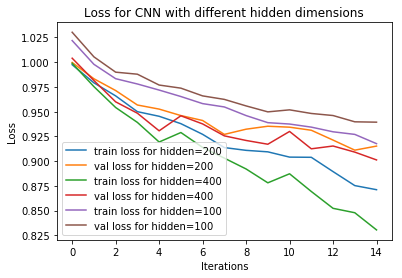

In [312]:
import matplotlib.pyplot as plt

plt.plot(train_loss_1, label = 'train loss for hidden=200')
plt.plot(val_loss_1, label = 'val loss for hidden=200')
plt.plot(train_loss_2, label = 'train loss for hidden=400')
plt.plot(val_loss_2, label = 'val loss for hidden=400')
plt.plot(train_loss_3, label = 'train loss for hidden=100')
plt.plot(val_loss_3, label = 'val loss for hidden=100')


plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.title('Loss for CNN with different hidden dimensions')
plt.savefig('losscnnhidden.png')
plt.show()

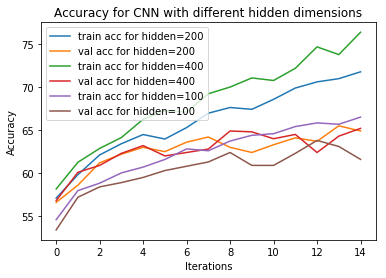

In [313]:
plt.plot(train_acc_1, label = 'train acc for hidden=200')
plt.plot(val_acc_1, label = 'val acc for hidden=200')
plt.plot(train_acc_2, label = 'train acc for hidden=400')
plt.plot(val_acc_2, label = 'val acc for hidden=400')
plt.plot(train_acc_3, label = 'train acc for hidden=100')
plt.plot(val_acc_3, label = 'val acc for hidden=100')


plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.title('Accuracy for CNN with different hidden dimensions')
plt.savefig('acccnnhidden.png')
plt.show()

In [316]:
model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=200, num_layers=2, num_classes=3, kernel=5, pad=2, emb_size=300, dropout=0)
train_acc_4, train_loss_4, val_acc_4, val_loss_4 = train_model(model, 3e-4, 5, 0)

The number of trained parameters: 1041203
Epoch: [1/5], Step: [1001/3125], Train Loss: 1.000838910446167, Train Acc: 55.999, Validation Loss: 1.0055720657110214, Validation Acc: 55.9
Epoch: [1/5], Step: [2001/3125], Train Loss: 0.9767464064598084, Train Acc: 57.31, Validation Loss: 0.9890604112297297, Validation Acc: 55.3
Epoch: [1/5], Step: [3001/3125], Train Loss: 0.9737277301216125, Train Acc: 58.303, Validation Loss: 0.9818374402821064, Validation Acc: 57.1
Epoch: [2/5], Step: [1001/3125], Train Loss: 0.955315528087616, Train Acc: 62.979, Validation Loss: 0.9657220020890236, Validation Acc: 61.2
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.9444292917633057, Train Acc: 63.798, Validation Loss: 0.9563108384609222, Validation Acc: 61.1
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9299954452896119, Train Acc: 66.107, Validation Loss: 0.9407782331109047, Validation Acc: 64.7
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.9191317563247681, Train Acc: 66.529, Validation Loss: 0.939994

In [202]:
model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=200, num_layers=2, num_classes=3, kernel=7, pad=3, emb_size=300, dropout=0)
train_acc_5, train_loss_5, val_acc_5, val_loss_5 = train_model(model, 3e-4, 5, 0)

Epoch: [1/5], Step: [1001/3125], Train Loss: 1.004422613658905, Train Acc: 56.909, Validation Loss: 1.0084396842867136, Validation Acc: 56.1
Epoch: [1/5], Step: [2001/3125], Train Loss: 0.9723629469108581, Train Acc: 60.787, Validation Loss: 0.9796039406210184, Validation Acc: 58.8
Epoch: [1/5], Step: [3001/3125], Train Loss: 0.9664509553527832, Train Acc: 62.553, Validation Loss: 0.9733694698661566, Validation Acc: 59.9
Epoch: [2/5], Step: [1001/3125], Train Loss: 0.9441801370048523, Train Acc: 64.355, Validation Loss: 0.9516938924789429, Validation Acc: 62.4
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.9381246371841431, Train Acc: 65.143, Validation Loss: 0.9496454317122698, Validation Acc: 62.6
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9292383679389954, Train Acc: 65.817, Validation Loss: 0.9489267021417618, Validation Acc: 61.5
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.9131642036628723, Train Acc: 67.133, Validation Loss: 0.9340526331216097, Validation Acc: 62.8
Epoch: 

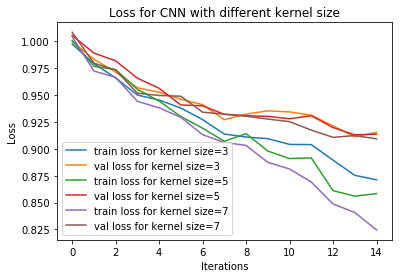

In [317]:
plt.plot(train_loss_1, label = 'train loss for kernel size=3')
plt.plot(val_loss_1, label = 'val loss for kernel size=3')
plt.plot(train_loss_4, label = 'train loss for kernel size=5')
plt.plot(val_loss_4, label = 'val loss for kernel size=5')
plt.plot(train_loss_5, label = 'train loss for kernel size=7')
plt.plot(val_loss_5, label = 'val loss for kernel size=7')


plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.title('Loss for CNN with different kernel size')
plt.savefig('losscnnkernel.png')
plt.show()

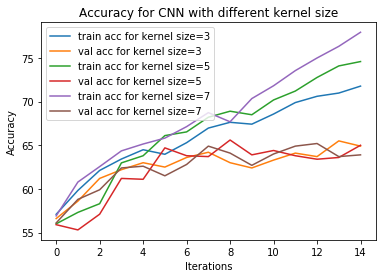

In [318]:
plt.plot(train_acc_1, label = 'train acc for kernel size=3')
plt.plot(val_acc_1, label = 'val acc for kernel size=3')
plt.plot(train_acc_4, label = 'train acc for kernel size=5')
plt.plot(val_acc_4, label = 'val acc for kernel size=5')
plt.plot(train_acc_5, label = 'train acc for kernel size=7')
plt.plot(val_acc_5, label = 'val acc for kernel size=7')


plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.title('Accuracy for CNN with different kernel size')
plt.savefig('acccnnkernel.png')
plt.show()

In [426]:
torch.save(model.state_dict(), 'best_cnn.pth')

# RNN based model

In [293]:
class RNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, num_classes, emb_size=300, dropout=0):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = emb_layer(weights_matrix, non_trainable=True)
        self.embedding.weight.requires_grad=False
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.linear_1 = nn.Linear(hidden_size*4, hidden_size*2)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(hidden_size*2, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)

        return hidden

    def forward(self, x_1, lengths_1, x_2, lengths_2):
        # reset hidden state

        batch_size_1, seq_len_1 = x_1.size()
        batch_size_2, seq_len_2 = x_2.size()
        
        _, idx_sort_1 = torch.sort(lengths_1, dim=0, descending=True)
        _, idx_unsort_1 = torch.sort(idx_sort_1, dim=0)
        _, idx_sort_2 = torch.sort(lengths_2, dim=0, descending=True)
        _, idx_unsort_2 = torch.sort(idx_sort_2, dim=0)

        self.hidden_1 = self.init_hidden(batch_size_1)
        self.hidden_2 = self.init_hidden(batch_size_2)

        # get embedding of characters
        embed_1 = self.embedding(x_1)
        embed_2 = self.embedding(x_2)
        # pack padded sequence
        embed_1 = embed_1.index_select(0, idx_sort_1)
        embed_1 = torch.nn.utils.rnn.pack_padded_sequence(embed_1, lengths_1.index_select(0, idx_sort_1).numpy(), batch_first=True)
        embed_2 = embed_2.index_select(0, idx_sort_2)
        embed_2 = torch.nn.utils.rnn.pack_padded_sequence(embed_2, lengths_2.index_select(0, idx_sort_2).numpy(), batch_first=True)
        # fprop though RNN
        rnn_out_1, self.hidden_1 = self.rnn(embed_1, self.hidden_1)
        
        rnn_out_2, self.hidden_2 = self.rnn(embed_2, self.hidden_2)                                
        # undo packing
        rnn_out_1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_1, batch_first=True)
        rnn_out_2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_2, batch_first=True)
        # sum hidden activations of RNN across time
        rnn_out_1 = torch.sum(rnn_out_1, dim=1)
        rnn_out_2 = torch.sum(rnn_out_2, dim=1)
        
        rnn_out_1 = rnn_out_1.index_select(0, idx_unsort_1)
        rnn_out_2 = rnn_out_2.index_select(0, idx_unsort_2)
        
        concat = torch.cat([rnn_out_1, rnn_out_2], 1)
        #concat = torch.sum(concat, dim=0)
        logits = self.relu(self.linear_1(concat))
        logits = self.dropout(logits)
        logits = self.linear_2(logits)
        return logits



In [294]:
model = RNN(weights_matrix=loaded_embeddings_ft, hidden_size=100, num_layers=2, num_classes=3, emb_size=300, dropout=0)
train_acc_6, train_loss_6, val_acc_6, val_loss_6 = train_model(model, 3e-4, 5, 0)

Epoch: [1/5], Step: [1001/3125], Train Loss: 1.0491022097015381, Train Acc: 49.049, Validation Loss: 1.0541357286274433, Validation Acc: 47.3
Epoch: [1/5], Step: [2001/3125], Train Loss: 1.0224321085357666, Train Acc: 54.394, Validation Loss: 1.0301008746027946, Validation Acc: 52.2
Epoch: [1/5], Step: [3001/3125], Train Loss: 0.9987065119552613, Train Acc: 56.348, Validation Loss: 1.0061500910669565, Validation Acc: 55.6
Epoch: [2/5], Step: [1001/3125], Train Loss: 0.9851284220314026, Train Acc: 58.334, Validation Loss: 0.9926747847348452, Validation Acc: 56.0
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.973836425819397, Train Acc: 59.943, Validation Loss: 0.9849535916000605, Validation Acc: 57.8
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9678702030754089, Train Acc: 60.777, Validation Loss: 0.9742270782589912, Validation Acc: 59.3
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.9503392707443238, Train Acc: 62.293, Validation Loss: 0.9537429362535477, Validation Acc: 62.7
Epoch: 

In [427]:
rnn_model = RNN(weights_matrix=loaded_embeddings_ft, hidden_size=200, num_layers=2, num_classes=3, emb_size=300, dropout=0)
train_acc_7, train_loss_7, val_acc_7, val_loss_7 = train_model(rnn_model, 3e-4, 5, 0)

The number of trained parameters: 1646403
Epoch: [1/5], Step: [1001/3125], Train Loss: 1.0570082541656494, Train Acc: 48.293, Validation Loss: 1.059999842196703, Validation Acc: 46.8
Epoch: [1/5], Step: [2001/3125], Train Loss: 1.0171307471466065, Train Acc: 53.591, Validation Loss: 1.024679884314537, Validation Acc: 52.2
Epoch: [1/5], Step: [3001/3125], Train Loss: 0.9943476838684082, Train Acc: 56.304, Validation Loss: 1.0032260902225971, Validation Acc: 55.9
Epoch: [2/5], Step: [1001/3125], Train Loss: 0.9803843768501281, Train Acc: 58.473, Validation Loss: 0.9929141905158758, Validation Acc: 56.5
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.9790270297622681, Train Acc: 60.254, Validation Loss: 0.9871372971683741, Validation Acc: 58.5
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9545414317512512, Train Acc: 61.747, Validation Loss: 0.9649767484515905, Validation Acc: 62.1
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.9416730851745605, Train Acc: 63.411, Validation Loss: 0.94438

In [296]:
model = RNN(weights_matrix=loaded_embeddings_ft, hidden_size=400, num_layers=2, num_classes=3, emb_size=300, dropout=0)
train_acc_8, train_loss_8, val_acc_8, val_loss_8 = train_model(model, 3e-4, 5, 0)

Epoch: [1/5], Step: [1001/3125], Train Loss: 1.0517699862098693, Train Acc: 49.204, Validation Loss: 1.0541488714516163, Validation Acc: 46.9
Epoch: [1/5], Step: [2001/3125], Train Loss: 1.0231812184333802, Train Acc: 53.848, Validation Loss: 1.0298682432621717, Validation Acc: 52.8
Epoch: [1/5], Step: [3001/3125], Train Loss: 0.9956761531448364, Train Acc: 56.267, Validation Loss: 1.0045753307640553, Validation Acc: 55.6
Epoch: [2/5], Step: [1001/3125], Train Loss: 0.9864512117195129, Train Acc: 57.802, Validation Loss: 0.9930743724107742, Validation Acc: 55.7
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.966945658378601, Train Acc: 60.537, Validation Loss: 0.9672323744744062, Validation Acc: 59.8
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9501721375656128, Train Acc: 62.187, Validation Loss: 0.9554921574890614, Validation Acc: 62.4
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.9430732136344909, Train Acc: 63.194, Validation Loss: 0.9446563739329576, Validation Acc: 63.2
Epoch: 

In [299]:
print('The number of trained parameters: {}'. format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

The number of trained parameters: 5852803


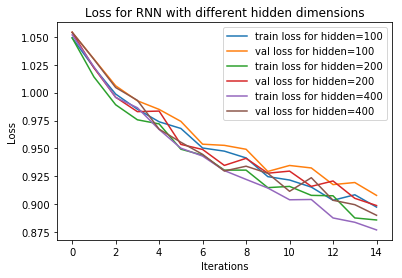

In [301]:
plt.plot(train_loss_6, label = 'train loss for hidden=100')
plt.plot(val_loss_6, label = 'val loss for hidden=100')
plt.plot(train_loss_7, label = 'train loss for hidden=200')
plt.plot(val_loss_7, label = 'val loss for hidden=200')
plt.plot(train_loss_8, label = 'train loss for hidden=400')
plt.plot(val_loss_8, label = 'val loss for hidden=400')


plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.title('Loss for RNN with different hidden dimensions')
plt.savefig('lossrnnhidden.png')
plt.show()


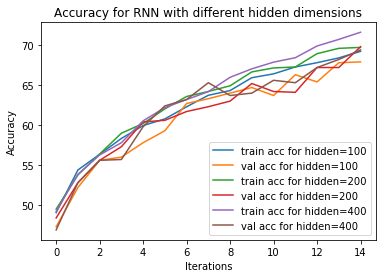

In [302]:
plt.plot(train_acc_6, label = 'train acc for hidden=100')
plt.plot(val_acc_6, label = 'val acc for hidden=100')
plt.plot(train_acc_7, label = 'train acc for hidden=200')
plt.plot(val_acc_7, label = 'val acc for hidden=200')
plt.plot(train_acc_8, label = 'train acc for hidden=400')
plt.plot(val_acc_8, label = 'val acc for hidden=400')


plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.title('Accuracy for RNN with different hidden dimensions')
plt.savefig('accrnnhidden.png')
plt.show()


In [303]:
model = RNN(weights_matrix=loaded_embeddings_ft, hidden_size=200, num_layers=2, num_classes=3, emb_size=300, dropout=0.2)
train_acc_9, train_loss_9, val_acc_9, val_loss_9 = train_model(model, 3e-4, 5, 0)

The number of trained parameters: 1646403
Epoch: [1/5], Step: [1001/3125], Train Loss: 1.0597099570846558, Train Acc: 48.301, Validation Loss: 1.0633874647319317, Validation Acc: 46.6
Epoch: [1/5], Step: [2001/3125], Train Loss: 1.0186541783714294, Train Acc: 53.746, Validation Loss: 1.024743728339672, Validation Acc: 49.9
Epoch: [1/5], Step: [3001/3125], Train Loss: 1.0048576378440857, Train Acc: 56.504, Validation Loss: 1.0134694874286652, Validation Acc: 54.7
Epoch: [2/5], Step: [1001/3125], Train Loss: 0.9885354467201233, Train Acc: 58.045, Validation Loss: 0.9987897537648678, Validation Acc: 56.9
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.9854436198234559, Train Acc: 58.714, Validation Loss: 0.9912642072886229, Validation Acc: 58.3
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9576080665016174, Train Acc: 61.234, Validation Loss: 0.9678521007299423, Validation Acc: 59.7
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.9469598149871826, Train Acc: 62.793, Validation Loss: 0.9545

In [304]:
model = RNN(weights_matrix=loaded_embeddings_ft, hidden_size=200, num_layers=2, num_classes=3, emb_size=300, dropout=0.5)
train_acc_10, train_loss_10, val_acc_10, val_loss_10 = train_model(model, 3e-4, 5, 0)

The number of trained parameters: 1646403
Epoch: [1/5], Step: [1001/3125], Train Loss: 1.0752871755599975, Train Acc: 43.88, Validation Loss: 1.084205187857151, Validation Acc: 39.2
Epoch: [1/5], Step: [2001/3125], Train Loss: 1.033887626247406, Train Acc: 52.433, Validation Loss: 1.0387644935399294, Validation Acc: 51.0
Epoch: [1/5], Step: [3001/3125], Train Loss: 1.0179608609580995, Train Acc: 54.424, Validation Loss: 1.0238910540938377, Validation Acc: 51.4
Epoch: [2/5], Step: [1001/3125], Train Loss: 0.9887854821395874, Train Acc: 56.748, Validation Loss: 1.002599997445941, Validation Acc: 55.1
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.988421778831482, Train Acc: 57.725, Validation Loss: 0.9967150334268808, Validation Acc: 57.2
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9771523662567139, Train Acc: 59.09, Validation Loss: 0.9859913382679224, Validation Acc: 58.0
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.9709148642539978, Train Acc: 60.531, Validation Loss: 0.978469397

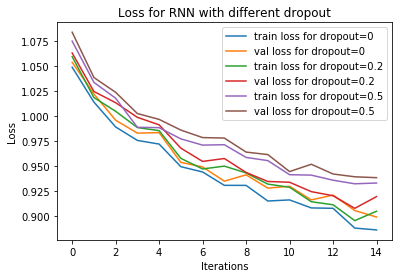

In [307]:
plt.plot(train_loss_7, label = 'train loss for dropout=0')
plt.plot(val_loss_7, label = 'val loss for dropout=0')
plt.plot(train_loss_9, label = 'train loss for dropout=0.2')
plt.plot(val_loss_9, label = 'val loss for dropout=0.2')
plt.plot(train_loss_10, label = 'train loss for dropout=0.5')
plt.plot(val_loss_10, label = 'val loss for dropout=0.5')


plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.title('Loss for RNN with different dropout')
plt.savefig('lossrnndropout.png')
plt.show()

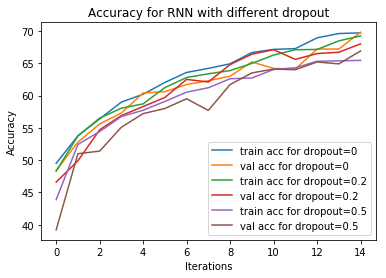

In [308]:
plt.plot(train_acc_7, label = 'train acc for dropout=0')
plt.plot(val_acc_7, label = 'val acc for dropout=0')
plt.plot(train_acc_9, label = 'train acc for dropout=0.2')
plt.plot(val_acc_9, label = 'val acc for dropout=0.2')
plt.plot(train_acc_10, label = 'train acc for dropout=0.5')
plt.plot(val_acc_10, label = 'val acc for dropout=0.5')


plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.title('Accuracy for RNN with different dropout')
plt.savefig('accrnndropout.png')
plt.show()

In [305]:
model = RNN(weights_matrix=loaded_embeddings_ft, hidden_size=200, num_layers=2, num_classes=3, emb_size=300, dropout=0)
train_acc_11, train_loss_11, val_acc_11, val_loss_11 = train_model(model, 3e-4, 5, 5e-4)

The number of trained parameters: 1646403
Epoch: [1/5], Step: [1001/3125], Train Loss: 1.051778535633087, Train Acc: 49.059, Validation Loss: 1.056483618915081, Validation Acc: 46.6
Epoch: [1/5], Step: [2001/3125], Train Loss: 1.016811092338562, Train Acc: 53.019, Validation Loss: 1.026266198605299, Validation Acc: 52.7
Epoch: [1/5], Step: [3001/3125], Train Loss: 1.0067775403785706, Train Acc: 54.996, Validation Loss: 1.0164327342063189, Validation Acc: 52.9
Epoch: [2/5], Step: [1001/3125], Train Loss: 1.0111829970741273, Train Acc: 55.003, Validation Loss: 1.0207592453807592, Validation Acc: 51.2
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.99116992603302, Train Acc: 56.299, Validation Loss: 1.0029962044209242, Validation Acc: 53.6
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9979344654464721, Train Acc: 56.765, Validation Loss: 1.0090836472809315, Validation Acc: 55.3
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.9874681309700012, Train Acc: 57.781, Validation Loss: 0.993288083

In [306]:
model = RNN(weights_matrix=loaded_embeddings_ft, hidden_size=200, num_layers=2, num_classes=3, emb_size=300, dropout=0)
train_acc_12, train_loss_12, val_acc_12, val_loss_12 = train_model(model, 3e-4, 5, 5e-5)

The number of trained parameters: 1646403
Epoch: [1/5], Step: [1001/3125], Train Loss: 1.0452386791610717, Train Acc: 48.964, Validation Loss: 1.0433378834277391, Validation Acc: 50.7
Epoch: [1/5], Step: [2001/3125], Train Loss: 1.0158354058074952, Train Acc: 53.905, Validation Loss: 1.022883640602231, Validation Acc: 52.3
Epoch: [1/5], Step: [3001/3125], Train Loss: 0.9976298439788819, Train Acc: 56.081, Validation Loss: 1.007188705727458, Validation Acc: 55.1
Epoch: [2/5], Step: [1001/3125], Train Loss: 0.98210069065094, Train Acc: 57.97, Validation Loss: 0.9880274031311274, Validation Acc: 56.8
Epoch: [2/5], Step: [2001/3125], Train Loss: 0.9863206458473206, Train Acc: 58.998, Validation Loss: 0.9940926376730204, Validation Acc: 57.1
Epoch: [2/5], Step: [3001/3125], Train Loss: 0.9722936443710327, Train Acc: 60.685, Validation Loss: 0.9798563104122877, Validation Acc: 59.3
Epoch: [3/5], Step: [1001/3125], Train Loss: 0.9547222444152832, Train Acc: 62.117, Validation Loss: 0.96297920

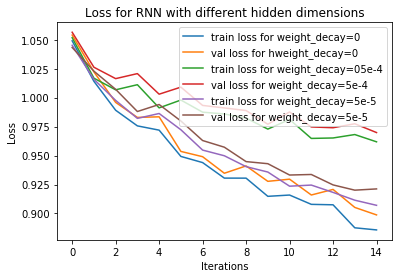

In [309]:
plt.plot(train_loss_7, label = 'train loss for weight_decay=0')
plt.plot(val_loss_7, label = 'val loss for hweight_decay=0')
plt.plot(train_loss_11, label = 'train loss for weight_decay=05e-4')
plt.plot(val_loss_11, label = 'val loss for weight_decay=5e-4')
plt.plot(train_loss_12, label = 'train loss for weight_decay=5e-5')
plt.plot(val_loss_12, label = 'val loss for weight_decay=5e-5')


plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.title('Loss for RNN with different hidden dimensions')
plt.savefig('lossrnnweight.png')
plt.show()

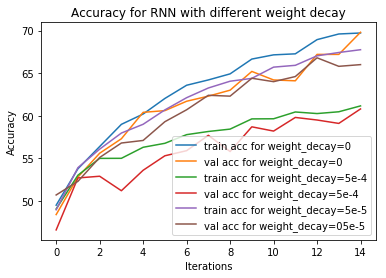

In [310]:
plt.plot(train_acc_7, label = 'train acc for weight_decay=0')
plt.plot(val_acc_7, label = 'val acc for weight_decay=0')
plt.plot(train_acc_11, label = 'train acc for weight_decay=5e-4')
plt.plot(val_acc_11, label = 'val acc for weight_decay=5e-4')
plt.plot(train_acc_12, label = 'train acc for weight_decay=5e-5')
plt.plot(val_acc_12, label = 'val acc for weight_decay=05e-5')


plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.title('Accuracy for RNN with different weight decay')
plt.savefig('accrnnweight.png')
plt.show()

In [443]:
torch.save(rnn_model.state_dict(), 'best_rnn.pth')

# Sample analysis

In [406]:
rnn_model.eval()

def generate_samples(loader, model):
    correct_sample = []
    incorrect_sample = []
    index = []
    for data_1, lengths_1, data_2, lengths_2, labels in loader:
        data_batch_1, length_batch_1, data_batch_2, length_batch_2, label_batch = \
        data_1, lengths_1, data_2, lengths_2, labels
        outputs = F.softmax(model(data_batch_1, length_batch_1, data_batch_2, length_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        #index += (predicted.numpy() == labels.view_as(predicted).numpy()).tolist()
        for i, prediction in enumerate(predicted):
            if prediction == labels[i]:
                correct_sample.append([' '.join(premise_val[i]), ' '.join(hypothesis_val[i]), targets_val[i], prediction])
            else:
                incorrect_sample.append([' '.join(premise_val[i]), ' '.join(hypothesis_val[i]), targets_val[i], prediction])
        break
    return correct_sample, incorrect_sample

In [407]:
correct_sample, incorrect_sample = generate_samples(val_loader, rnn_model)

In [408]:
for i in np.random.choice(len(correct_sample),3, replace=False):
    print('premise: {}'.format(correct_sample[i][0]))
    print('hypothesis: {}'.format(correct_sample[i][1]))
    print('target: {}'.format(correct_sample[i][2]))
    print('prediction: {}'.format(correct_sample[i][3].item()))
    print('**************************************************')

premise: a group of people are sitting under umbrellas on the beach .
hypothesis: it is a saturday
target: 2
prediction: 2
**************************************************
premise: two kids on a boat , one with a paddle , and the other on the edge wearing a life vest .
hypothesis: a kid is wearing a life vest .
target: 1
prediction: 1
**************************************************
premise: a group of people dressed in santa claus suits are looking towards an audience while a dj runs a sound board and another person throws green balls into the air .
hypothesis: a band plays at a beach party .
target: 2
prediction: 2
**************************************************


In [382]:
for i in np.random.choice(len(incorrect_sample),3, replace=False):
    print('premise: {}'.format(incorrect_sample[i][0]))
    print('hypothesis: {}'.format(incorrect_sample[i][1]))
    print('target: {}'.format(incorrect_sample[i][2]))
    print('prediction: {}'.format(incorrect_sample[i][3].item()))
    print('****************************************************')

premise: man grilling fish on barbecue
hypothesis: the man likes to eat fish .
target: 2
prediction: 1
****************************************************
premise: four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
hypothesis: multiple people are on a subway together , with each of them doing their own thing .
target: 1
prediction: 0
****************************************************
premise: three people and a white dog are sitting in the sand on a beach .
hypothesis: three dogs and a person are sitting in the snow .
target: 0
prediction: 1
****************************************************


# Evaluating on MultiNLI

In [429]:
#load mnli dataset
premise_test = []
hypothesis_test = []
targets_test = []
genre = []
with open("hw2_data/mnli_val.tsv") as tsvfile:
    fd = csv.reader(tsvfile, delimiter="\t")
    for row in fd:
        premise_test.append(row[0].lower().split())
        hypothesis_test.append(row[1].lower().split())
        if row[2] == 'contradiction':
            targets_test.append(0)
        elif row[2] == 'entailment':
            targets_test.append(1)
        elif row[2] == 'neutral':
            targets_test.append(2)
        genre.append(row[3])

In [430]:
premise_test = premise_test[1:]
hypothesis_test = hypothesis_test[1:]
genre = genre[1:]

In [431]:
genres = set(genre)
print(genres)

{'telephone', 'government', 'slate', 'travel', 'fiction'}


In [432]:
#check length of lists
print(len(premise_test))
print(len(hypothesis_test))
print(len(targets_test))
print(len(genre))

5000
5000
5000
5000


In [433]:
MAX_SENTENCE_LENGTH_1 = 82
MAX_SENTENCE_LENGTH_2 = 41

In [434]:
#Convert tokens to indices
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data


In [435]:
#Function for testing the model
def test_model_mnli(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    #loss = 0
    model.eval()
    for data_1, lengths_1, data_2, lengths_2, labels in loader:
        data_batch_1, length_batch_1, data_batch_2, length_batch_2,label_batch = data_1, lengths_1, data_2, lengths_2, labels
        outputs = F.softmax(model(data_batch_1, length_batch_1, data_batch_2, length_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        #loss_i = criterion(outputs, labels)
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        #loss += loss_i.item()
    return (100 * correct / total)

In [436]:
#telephone
premise_telephone = [sent for i, sent in enumerate(premise_test) if genre[i] == 'telephone']
hypothesis_telephone = [sent for i, sent in enumerate(hypothesis_test) if genre[i] == 'telephone']
targets_telephone = [tar for i, tar in enumerate(targets_test) if genre[i] == 'telephone']

premise_telephone_indices = token2index_dataset(premise_telephone)
hypothesis_telephone_indices = token2index_dataset(hypothesis_telephone)

telephone_dataset = SNLIDataset(premise_telephone_indices, hypothesis_telephone_indices, targets_telephone)
telephone_loader = torch.utils.data.DataLoader(dataset=telephone_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [437]:
#government
premise_government = [sent for i, sent in enumerate(premise_test) if genre[i] == 'government']
hypothesis_government = [sent for i, sent in enumerate(hypothesis_test) if genre[i] == 'government']
targets_government = [tar for i, tar in enumerate(targets_test) if genre[i] == 'government']

premise_government_indices = token2index_dataset(premise_government)
hypothesis_government_indices = token2index_dataset(hypothesis_government)

government_dataset = SNLIDataset(premise_government_indices, hypothesis_government_indices, targets_government)
government_loader = torch.utils.data.DataLoader(dataset=government_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [438]:
#slate
premise_slate = [sent for i, sent in enumerate(premise_test) if genre[i] == 'slate']
hypothesis_slate = [sent for i, sent in enumerate(hypothesis_test) if genre[i] == 'slate']
targets_slate = [tar for i, tar in enumerate(targets_test) if genre[i] == 'slate']

premise_slate_indices = token2index_dataset(premise_slate)
hypothesis_slate_indices = token2index_dataset(hypothesis_slate)

slate_dataset = SNLIDataset(premise_slate_indices, hypothesis_slate_indices, targets_slate)
slate_loader = torch.utils.data.DataLoader(dataset=slate_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [439]:
#travel
premise_travel = [sent for i, sent in enumerate(premise_test) if genre[i] == 'travel']
hypothesis_travel = [sent for i, sent in enumerate(hypothesis_test) if genre[i] == 'travel']
targets_travel = [tar for i, tar in enumerate(targets_test) if genre[i] == 'travel']

premise_travel_indices = token2index_dataset(premise_travel)
hypothesis_travel_indices = token2index_dataset(hypothesis_travel)

travel_dataset = SNLIDataset(premise_travel_indices, hypothesis_travel_indices, targets_travel)
travel_loader = torch.utils.data.DataLoader(dataset=travel_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [440]:
#fiction
premise_fiction = [sent for i, sent in enumerate(premise_test) if genre[i] == 'fiction']
hypothesis_fiction = [sent for i, sent in enumerate(hypothesis_test) if genre[i] == 'fiction']
targets_fiction = [tar for i, tar in enumerate(targets_test) if genre[i] == 'fiction']

premise_fiction_indices = token2index_dataset(premise_fiction)
hypothesis_fiction_indices = token2index_dataset(hypothesis_fiction)

fiction_dataset = SNLIDataset(premise_fiction_indices, hypothesis_fiction_indices, targets_fiction)
fiction_loader = torch.utils.data.DataLoader(dataset=fiction_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [444]:
state_dict_cnn = torch.load('best_cnn.pth')
model.load_state_dict(state_dict_cnn)

state_dict_rnn = torch.load('best_rnn.pth')
rnn_model.load_state_dict(state_dict_rnn)

In [464]:
print('Val acc for CNN model: {} on telephone'.format(test_model_mnli(telephone_loader, model)))
print('Val acc for RNN model: {} on telephone'.format(test_model_mnli(telephone_loader, rnn_model)))
print('*********************************************')
print('Val acc for CNN model: {} on government'.format(test_model_mnli(government_loader, model)))
print('Val acc for RNN model: {} on government'.format(test_model_mnli(government_loader, rnn_model)))
print('*********************************************')
print('Val acc for CNN model: {} on slate'.format(test_model_mnli(slate_loader, model)))
print('Val acc for RNN model: {} on slate'.format(test_model_mnli(slate_loader, rnn_model)))
print('*********************************************')
print('Val acc for CNN model: {} on travel'.format(test_model_mnli(travel_loader, model)))
print('Val acc for RNN model: {} on tavel'.format(test_model_mnli(travel_loader, rnn_model)))
print('*********************************************')
print('Val acc for CNN model: {} on fiction'.format(test_model_mnli(fiction_loader, model)))
print('Val acc for RNN model: {} on fiction'.format(test_model_mnli(fiction_loader, rnn_model)))

Val acc for CNN model: 46.766169154228855 on telephone
Val acc for RNN model: 51.74129353233831 on telephone
*********************************************
Val acc for CNN model: 44.78346456692913 on government
Val acc for RNN model: 49.50787401574803 on government
*********************************************
Val acc for CNN model: 41.71656686626746 on slate
Val acc for RNN model: 45.30938123752495 on slate
*********************************************
Val acc for CNN model: 46.13034623217923 on travel
Val acc for RNN model: 46.435845213849284 on tavel
*********************************************
Val acc for CNN model: 47.1356783919598 on fiction
Val acc for RNN model: 47.8391959798995 on fiction


# Fine-tuning on MultiNLI

In [446]:
mp_train = []
mh_train = []
m_targets = []
genre_train = []
with open("hw2_data/mnli_train.tsv") as tsvfile:
    fd = csv.reader(tsvfile, delimiter="\t")
    for row in fd:
        mp_train.append(row[0].lower().split())
        mh_train.append(row[1].lower().split())
        if row[2] == 'contradiction':
            m_targets.append(0)
        elif row[2] == 'entailment':
            m_targets.append(1)
        elif row[2] == 'neutral':
            m_targets.append(2)
        genre_train.append(row[3])

In [447]:
mp_train = mp_train[1:]
mh_train = mh_train[1:]
genre_train = genre_train[1:]

In [448]:
#telephone
mp_telephone = [sent for i, sent in enumerate(mp_train) if genre_train[i] == 'telephone']
mh_telephone = [sent for i, sent in enumerate(mh_train) if genre_train[i] == 'telephone']
targets_train_telephone = [tar for i, tar in enumerate(m_targets) if genre_train[i] == 'telephone']

mp_telephone_indices = token2index_dataset(mp_telephone)
mh_telephone_indices = token2index_dataset(mh_telephone)

telephone_dataset_train = SNLIDataset(mp_telephone_indices, mh_telephone_indices, targets_train_telephone)
telephone_loader_train = torch.utils.data.DataLoader(dataset=telephone_dataset_train,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [449]:
#government
mp_government = [sent for i, sent in enumerate(mp_train) if genre_train[i] == 'government']
mh_government = [sent for i, sent in enumerate(mh_train) if genre_train[i] == 'government']
targets_train_government = [tar for i, tar in enumerate(m_targets) if genre_train[i] == 'government']

mp_government_indices = token2index_dataset(mp_government)
mh_government_indices = token2index_dataset(mh_government)

government_dataset_train = SNLIDataset(mp_government_indices, mh_government_indices, targets_train_government)
government_loader_train = torch.utils.data.DataLoader(dataset=government_dataset_train,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [450]:
#slate
mp_slate = [sent for i, sent in enumerate(mp_train) if genre_train[i] == 'slate']
mh_slate = [sent for i, sent in enumerate(mh_train) if genre_train[i] == 'slate']
targets_train_slate = [tar for i, tar in enumerate(m_targets) if genre_train[i] == 'slate']

mp_slate_indices = token2index_dataset(mp_slate)
mh_slate_indices = token2index_dataset(mh_slate)

slate_dataset_train = SNLIDataset(mp_slate_indices, mh_slate_indices, targets_train_slate)
slate_loader_train = torch.utils.data.DataLoader(dataset=slate_dataset_train,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [451]:
#travel
mp_travel = [sent for i, sent in enumerate(mp_train) if genre_train[i] == 'travel']
mh_travel = [sent for i, sent in enumerate(mh_train) if genre_train[i] == 'travel']
targets_train_travel = [tar for i, tar in enumerate(m_targets) if genre_train[i] == 'travel']

mp_travel_indices = token2index_dataset(mp_travel)
mh_travel_indices = token2index_dataset(mh_travel)

travel_dataset_train = SNLIDataset(mp_travel_indices, mh_travel_indices, targets_train_travel)
travel_loader_train = torch.utils.data.DataLoader(dataset=travel_dataset_train,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [452]:
#fiction
mp_fiction = [sent for i, sent in enumerate(mp_train) if genre_train[i] == 'fiction']
mh_fiction = [sent for i, sent in enumerate(mh_train) if genre_train[i] == 'fiction']
targets_train_fiction = [tar for i, tar in enumerate(m_targets) if genre_train[i] == 'fiction']

mp_fiction_indices = token2index_dataset(mp_fiction)
mh_fiction_indices = token2index_dataset(mh_fiction)

fiction_dataset_train = SNLIDataset(mp_fiction_indices, mh_fiction_indices, targets_train_fiction)
fiction_loader_train = torch.utils.data.DataLoader(dataset=fiction_dataset_train,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [470]:
#Function for training the model
def train_model_mnli(model, data_train_loader, data_val_loader, learning_rate, num_epochs, weight_decay):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('The number of trained parameters: {}'.format(total_params))
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
    #scheduler.step()
        for i, (data_1, lengths_1, data_2, lengths_2, labels) in enumerate(data_train_loader):
            model.train()
            #data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_1, lengths_1, data_2, lengths_2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                train_acc, train_loss = test_model(data_train_loader, model)
                val_acc, val_loss = test_model(data_val_loader, model)
            
                train_acc_list.append(train_acc)
                train_loss_list.append(train_loss)
                val_acc_list.append(val_acc)
                val_loss_list.append(val_loss)
                print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Train Acc: {}, Validation Loss: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(data_train_loader), train_loss, train_acc, val_loss, val_acc))
    
    print ("After training for {} epochs".format(num_epochs))
    print ("Val Acc {}".format(test_model_mnli(data_val_loader, model)))
    #return train_acc_list, train_loss_list, val_acc_list, val_loss_list

In [471]:
rnn_model.load_state_dict(state_dict_rnn)
train_model_mnli(rnn_model, telephone_loader_train, telephone_loader, 1e-5, 5, 0)
#print(test_model_mnli(telephone_loader, rnn_model))

The number of trained parameters: 1646403
Epoch: [1/5], Step: [101/134], Train Loss: 1.048885740006148, Train Acc: 46.323185011709604, Validation Loss: 1.0446821954101324, Validation Acc: 47.2636815920398
Epoch: [2/5], Step: [101/134], Train Loss: 1.048415987794079, Train Acc: 47.002341920374704, Validation Loss: 1.0390712264925241, Validation Acc: 48.85572139303483
Epoch: [3/5], Step: [101/134], Train Loss: 1.0470576926843445, Train Acc: 47.84543325526932, Validation Loss: 1.040342653170228, Validation Acc: 50.34825870646766
Epoch: [4/5], Step: [101/134], Train Loss: 1.045653505111808, Train Acc: 48.875878220140514, Validation Loss: 1.039919052273035, Validation Acc: 48.85572139303483
Epoch: [5/5], Step: [101/134], Train Loss: 1.0450059887188583, Train Acc: 49.18032786885246, Validation Loss: 1.0420276075601578, Validation Acc: 51.04477611940298
After training for 5 epochs
Val Acc 50.646766169154226


In [472]:
rnn_model.load_state_dict(state_dict_rnn)
train_model_mnli(rnn_model, government_loader_train, government_loader, 1e-5, 5, 0)
#print(test_model_mnli(government_loader, rnn_model))

The number of trained parameters: 1646403
Epoch: [1/5], Step: [101/122], Train Loss: 1.0278737559670308, Train Acc: 50.115889775946435, Validation Loss: 1.02966289781034, Validation Acc: 48.72047244094488
Epoch: [2/5], Step: [101/122], Train Loss: 1.0262393614307779, Train Acc: 50.888488282255985, Validation Loss: 1.0277432054281235, Validation Acc: 50.29527559055118
Epoch: [3/5], Step: [101/122], Train Loss: 1.024921342486241, Train Acc: 52.124645892351275, Validation Loss: 1.0251675695180893, Validation Acc: 50.49212598425197
Epoch: [4/5], Step: [101/122], Train Loss: 1.0213958625910713, Train Acc: 53.000257532835434, Validation Loss: 1.0194100141525269, Validation Acc: 51.673228346456696
Epoch: [5/5], Step: [101/122], Train Loss: 1.020171335486115, Train Acc: 53.30929693535926, Validation Loss: 1.0186380464583635, Validation Acc: 54.232283464566926
After training for 5 epochs
Val Acc 52.36220472440945


In [473]:
rnn_model.load_state_dict(state_dict_rnn)
train_model_mnli(rnn_model, slate_loader_train, slate_loader, 1e-5, 5, 0)
#print(test_model_mnli(slate_loader, rnn_model))

The number of trained parameters: 1646403
Epoch: [1/5], Step: [101/126], Train Loss: 1.0561963513730064, Train Acc: 44.38648782911078, Validation Loss: 1.06466194242239, Validation Acc: 41.417165668662676
Epoch: [2/5], Step: [101/126], Train Loss: 1.0552187590371995, Train Acc: 45.57873820168902, Validation Loss: 1.0620269775390625, Validation Acc: 44.01197604790419
Epoch: [3/5], Step: [101/126], Train Loss: 1.0528939574483842, Train Acc: 47.24292101341282, Validation Loss: 1.0596169903874397, Validation Acc: 45.60878243512974
Epoch: [4/5], Step: [101/126], Train Loss: 1.0520702510599107, Train Acc: 47.168405365126674, Validation Loss: 1.0591230262070894, Validation Acc: 46.20758483033932
Epoch: [5/5], Step: [101/126], Train Loss: 1.0507742781487723, Train Acc: 48.06259314456036, Validation Loss: 1.0620463006198406, Validation Acc: 45.10978043912176
After training for 5 epochs
Val Acc 46.30738522954092


In [474]:
rnn_model.load_state_dict(state_dict_rnn)
train_model_mnli(rnn_model, travel_loader_train, travel_loader, 1e-5, 5, 0)
#print(test_model_mnli(travel_loader, rnn_model)

The number of trained parameters: 1646403
Epoch: [1/5], Step: [101/125], Train Loss: 1.0392394580841064, Train Acc: 48.431618569636136, Validation Loss: 1.0379969112334713, Validation Acc: 45.926680244399186
Epoch: [2/5], Step: [101/125], Train Loss: 1.0353342485427857, Train Acc: 49.184441656210794, Validation Loss: 1.0354138497383363, Validation Acc: 47.759674134419555
Epoch: [3/5], Step: [101/125], Train Loss: 1.0336835265159607, Train Acc: 50.89084065244668, Validation Loss: 1.0341128860750506, Validation Acc: 48.676171079429736
Epoch: [4/5], Step: [101/125], Train Loss: 1.0321468291282654, Train Acc: 50.84065244667503, Validation Loss: 1.032999905847734, Validation Acc: 49.18533604887984
Epoch: [5/5], Step: [101/125], Train Loss: 1.0286773681640624, Train Acc: 52.02007528230866, Validation Loss: 1.032809192134488, Validation Acc: 49.08350305498982
After training for 5 epochs
Val Acc 49.287169042769854


In [475]:
rnn_model.load_state_dict(state_dict_rnn)
train_model_mnli(rnn_model, fiction_loader_train, fiction_loader, 1e-5, 5, 0)
#print(test_model_mnli(fiction_loader, rnn_model))

The number of trained parameters: 1646403
Epoch: [1/5], Step: [101/120], Train Loss: 1.0449052015940348, Train Acc: 47.1584984358707, Validation Loss: 1.0428750589489937, Validation Acc: 47.537688442211056
Epoch: [2/5], Step: [101/120], Train Loss: 1.0425782625873883, Train Acc: 49.035453597497394, Validation Loss: 1.0432369019836187, Validation Acc: 49.54773869346734
Epoch: [3/5], Step: [101/120], Train Loss: 1.0416926751534143, Train Acc: 50.1303441084463, Validation Loss: 1.0360346268862486, Validation Acc: 48.84422110552764
Epoch: [4/5], Step: [101/120], Train Loss: 1.0410290335615475, Train Acc: 50.18248175182482, Validation Loss: 1.0425814185291529, Validation Acc: 49.949748743718594
Epoch: [5/5], Step: [101/120], Train Loss: 1.0404511903723082, Train Acc: 50.886339937434826, Validation Loss: 1.0434596315026283, Validation Acc: 50.653266331658294
After training for 5 epochs
Val Acc 47.03517587939699
